<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step4_sparktorch_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download preprocessed dataset
!wget -qO ratings_M50.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EWqG6YIAGfpLihYVvtpMeRQB1ngfhPZPydHCoUL87QR3yA?download=1
!wget -qO ratings_M1000.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/ESYy4ukVKs9DkY6-YVBh-0kBr5uQE29dC1Tq0PRi_tJJhg?download=1

In [ ]:
!pip -q install sparktorch pyspark

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from sparktorch import serialize_torch_obj, SparkTorch
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, floor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
ps.options.display.max_rows = 5

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# read dataset into dataframe

spark = SparkSession.builder.appName("MyApp").master('local').getOrCreate()
df = ps.read_csv('ratings_M50.csv')
df['label'] = df.rating / 6
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


num_user: 111 num_movie: 50


,user,movie,rating,label
0,0,0,4,0.666667
1,1,0,3,0.500000
2,2,0,2,0.333333
3,3,0,4,0.666667
4,4,0,4,0.666667


In [3]:
# split data into train and test sets

max_test_split = 0.2        # for a smaller dataset, we take 20% for test
max_test_num = 100_000      # for a larger dataset, we take 100_000 only
num_fold = 1 / min(max_test_num/len(df), max_test_split)

df = df.to_spark().withColumn('fold', floor(rand()*num_fold))
df_train = df.filter(col('fold') != 0)
df_test  = df.filter(col('fold') == 0)

va = VectorAssembler(inputCols=['user', 'movie'], outputCol='features')
df_train = va.transform(df_train)
df_test  = va.transform(df_test)

df_train.show(5)
df_test.show(5)

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+----+-----+------+-------------------+----+---------+
|user|movie|rating|              label|fold| features|
+----+-----+------+-------------------+----+---------+
|   0|    0|     4| 0.6666666666666666|   1|(2,[],[])|
|   2|    0|     2| 0.3333333333333333|   3|[2.0,0.0]|
|   3|    0|     4| 0.6666666666666666|   4|[3.0,0.0]|
|   5|    0|     2| 0.3333333333333333|   2|[5.0,0.0]|
|   6|    0|     1|0.16666666666666666|   4|[6.0,0.0]|
+----+-----+------+-------------------+----+---------+
only showing top 5 rows

+----+-----+------+------------------+----+----------+
|user|movie|rating|             label|fold|  features|
+----+-----+------+------------------+----+----------+
|   1|    0|     3|               0.5|   0| [1.0,0.0]|
|   4|    0|     4|0.6666666666666666|   0| [4.0,0.0]|
|   9|    0|     4|0.6666666666666666|   0| [9.0,0.0]|
|  18|    0|     5|0.8333333333333334|   0|[18.0,0.0]|
|  24|    0|     3|               0.5|   0|[24.0,0.0]|
+----+-----+------+------------------+--

In [4]:
# build the matrix-multiplication-based model

class MatrixMultiplicationModel(nn.Module):
    def __init__(self, num_user, num_movie, emb_dim):
        super().__init__()
        self.U = nn.Embedding(num_user, emb_dim)    # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(num_movie, emb_dim)   # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, um_idxs):
        u_idx, m_idx = um_idxs[:,0].int(), um_idxs[:,1].int()
        U = self.U(u_idx)                           # retrieve user embeddings by user indexes
        V = self.V(m_idx)                           # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)             # predicted ratings are their dot products
        # output = torch.sigmoid(dot_products)      # map to [0,1]
        output = dot_products
        return output

In [5]:
# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
batch_size = 256
max_loop = 200_000
report_per_nloop = 100
patience = 10       # early stop if not improving in this num of evaluations
optimizer=torch.optim.Adam

# initialize model and ...
py_model = MatrixMultiplicationModel(num_user =N,
                                     num_movie=M,
                                     emb_dim  =D)
criterion = nn.MSELoss()
Optimizer = optim.Adam

# Build the pytorch object
torch_obj = serialize_torch_obj(
    model=py_model,
    criterion=criterion,
    optimizer=Optimizer,
    lr=lr,
)

In [6]:
# prepare test data
test_x = torch.IntTensor(df_test.select('user', 'movie').collect())
test_y = torch.FloatTensor(df_test.select('label').collect()).squeeze()

In [7]:
# train

min_test_loss = None
recs = []
for i in range(max_loop):
    
    # fit for {report_per_nloop} loops
    torch_obj = serialize_torch_obj(
        model=py_model,
        criterion=criterion,
        optimizer=Optimizer,
        lr=lr,
    )
    spark_model = SparkTorch(
        inputCol='features',
        labelCol='label',
        predictionCol='prediction',
        torchObj=torch_obj,
        iters=report_per_nloop,
        miniBatch=batch_size,
        verbose=1,
    ).fit(df_train)

    # calculate test loss
    py_model = spark_model.getPytorchModel()
    with torch.no_grad():
        test_y_hat = py_model(test_x)
    test_loss = criterion(test_y_hat, test_y).item()

    rec = {
        'batch'     : i*report_per_nloop,
        'test_loss' : test_loss,
    }
    recs.append(rec)
    print(rec)

    # check for early stopping
    if min_test_loss is None or test_loss < min_test_loss:
        min_test_loss = test_loss
        not_improving_count = 0
    else:
        not_improving_count += 1
        if not_improving_count >= patience:
            break

{'batch': 0, 'test_loss': 7.4906005859375}


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([323, 1])) that is different to the input size (torch.Size([323])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


{'batch': 100, 'test_loss': 6.312375545501709}
{'batch': 200, 'test_loss': 5.30979585647583}
{'batch': 300, 'test_loss': 4.488776683807373}
{'batch': 400, 'test_loss': 3.8037056922912598}
{'batch': 500, 'test_loss': 3.2397568225860596}
{'batch': 600, 'test_loss': 2.7720396518707275}
{'batch': 700, 'test_loss': 2.3851144313812256}
{'batch': 800, 'test_loss': 2.062774419784546}
{'batch': 900, 'test_loss': 1.8003696203231812}
{'batch': 1000, 'test_loss': 1.5807698965072632}
{'batch': 1100, 'test_loss': 1.4140002727508545}
{'batch': 1200, 'test_loss': 1.2741007804870605}
{'batch': 1300, 'test_loss': 1.159235954284668}
{'batch': 1400, 'test_loss': 1.0648193359375}
{'batch': 1500, 'test_loss': 0.9940411448478699}
{'batch': 1600, 'test_loss': 0.9259210824966431}
{'batch': 1700, 'test_loss': 0.8699048757553101}
{'batch': 1800, 'test_loss': 0.8241627812385559}
{'batch': 1900, 'test_loss': 0.7802293300628662}
{'batch': 2000, 'test_loss': 0.7404780387878418}
{'batch': 2100, 'test_loss': 0.7011469

<Axes: xlabel='batch'>

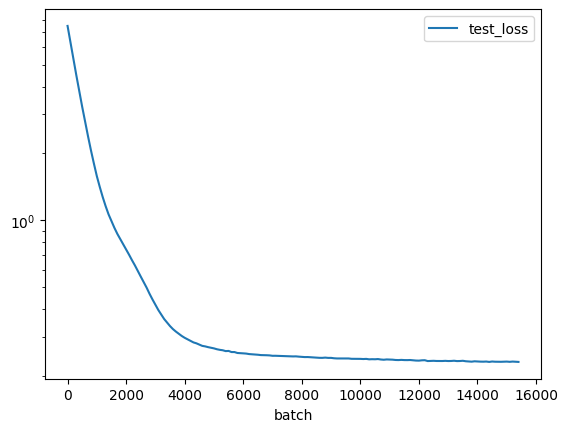

In [11]:
# training curves
pd.DataFrame(recs).set_index('batch')[['test_loss']].plot(logy=True)

In [12]:
# resulted U and V
U = py_model.U.weight
V = py_model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[ 0.6967,  0.6866,  0.0280,  0.1050,  0.3767,  1.1250, -0.7690, -0.2510,
         -0.4349, -0.2069],
        [-0.0032,  0.4835,  0.1148,  0.1132,  0.3690,  1.6749, -0.6475, -0.0955,
          0.2919,  0.6920],
        [-0.5016, -0.4060,  0.7731,  0.1813, -0.6502,  1.1282, -0.4825, -0.3310,
          0.0756,  0.4406]], grad_fn=<SliceBackward0>)
V: tensor([[-1.3139e-01, -1.2171e-01, -5.8159e-01,  1.6790e-01, -3.8479e-01,
          9.9550e-02, -8.4584e-01,  8.3006e-02, -6.1765e-02,  2.5607e-03],
        [ 3.1243e-01,  6.1670e-01,  1.5600e-01,  4.5107e-01, -9.2874e-01,
         -1.2377e+00, -1.0072e+00,  4.6784e-01,  3.7709e-01,  1.3670e+00],
        [-8.8881e-02, -3.4260e-01, -9.4524e-02, -2.4638e-01, -4.3292e-02,
          6.5917e-01, -3.8155e-02,  4.4153e-01, -1.0540e-03, -6.0763e-01]],
       grad_fn=<SliceBackward0>)


In [13]:
# prediction results

with torch.no_grad():
    test_y_hat = py_model(test_x)

df_res = (
    df_test.toPandas()
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,label,fold,features,target_pred,rating_pred,rating_residual
141,34,24,1,0.166667,0,"[34.0, 24.0]",0.449247,2.695485,-1.695485
194,35,29,4,0.666667,0,"[35.0, 29.0]",0.443900,2.663400,1.336600
281,7,44,1,0.166667,0,"[7.0, 44.0]",0.445544,2.673267,-1.673267
291,10,45,4,0.666667,0,"[10.0, 45.0]",0.510801,3.064806,0.935194
13,54,2,1,0.166667,0,"[54.0, 2.0]",0.440918,2.645509,-1.645509
124,0,23,1,0.166667,0,"[0.0, 23.0]",0.446684,2.680102,-1.680102
135,110,23,3,0.500000,0,"[110.0, 23.0]",0.433896,2.603377,0.396623
79,53,16,2,0.333333,0,"[53.0, 16.0]",0.429391,2.576344,-0.576344
47,79,11,1,0.166667,0,"[79.0, 11.0]",-1.207856,1.000000,0.000000
36,2,8,1,0.166667,0,"[2.0, 8.0]",-0.129260,1.000000,0.000000


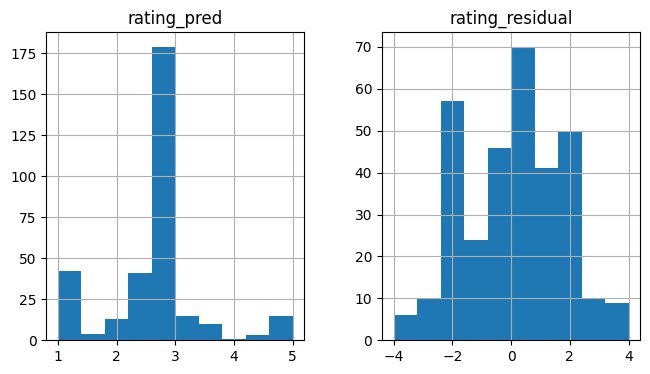

In [14]:
# distribution of residuals
df_res[['rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()